In [78]:
import pandas as pd
import numpy as np
import requests
from ydata_profiling import ProfileReport
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import featuretools as ft
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

In [147]:
# Function to fetch data for a given date range
def fetch_hourly_data(start_date, end_date):
    url = "https://meteostat.p.rapidapi.com/point/hourly"

    querystring = {
        "lat": 24.8607,
        "lon": 67.0011,
        "alt": 8,
        "start": start_date,
        "end": end_date,
        "hourly": "temperature_2m,humidity_2m,precipitation,wind_speed_10m"
    }

    headers = {
        "x-rapidapi-key": "419b68c0aamsha9464d4db64ac17p149a24jsn9884114c5ab9",
        "x-rapidapi-host": "meteostat.p.rapidapi.com"
    }

    # Make API request
    response = requests.get(url, headers=headers, params=querystring)

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        if "data" in data:
            return data["data"]
        else:
            print(f"❌ No data found for {start_date} to {end_date}")
    else:
        print(f"❌ HTTP error {response.status_code} for {start_date} to {end_date}")
        print(response.text)
    return None

# Get today's date and calculate the start date (1 year ago)
end_date = datetime.today()
start_date = end_date - timedelta(days=365)  # 1 year ago

# Convert dates to string format (YYYY-MM-DD)
end_date_str = end_date.strftime("%Y-%m-%d")
start_date_str = start_date.strftime("%Y-%m-%d")

# Create a list to store the data
all_data = []

# Loop over the range in 30-day intervals
current_start = start_date
current_end = current_start + timedelta(days=29)

while current_start <= end_date:
    # Ensure the end date doesn't go beyond todaygit stat
    if current_end > end_date:
        current_end = end_date
    
    # Format dates back to string for query
    start_str = current_start.strftime("%Y-%m-%d")
    end_str = current_end.strftime("%Y-%m-%d")
    
    # Fetch data for this interval
    data = fetch_hourly_data(start_str, end_str)
    if data:
        # Add the data to the list
        all_data.extend(data)
        print(f"✅ Data fetched from {start_str} to {end_str}")
    
    # Move to the next 30-day interval
    current_start = current_end + timedelta(days=1)
    current_end = current_start + timedelta(days=29)

# After all data is fetched, convert to DataFrame and save
if all_data:
    df = pd.DataFrame(all_data)
    df.to_csv("Karachi_weather_hourly_last_year.csv", index=False)
    print("✅ All data saved to 'Karachi_weather_hourly_last_year.csv'")
else:
    print("❌ No data collected.")



✅ Data fetched from 2024-04-30 to 2024-05-29
✅ Data fetched from 2024-05-30 to 2024-06-28
✅ Data fetched from 2024-06-29 to 2024-07-28
✅ Data fetched from 2024-07-29 to 2024-08-27
✅ Data fetched from 2024-08-28 to 2024-09-26
✅ Data fetched from 2024-09-27 to 2024-10-26
✅ Data fetched from 2024-10-27 to 2024-11-25
✅ Data fetched from 2024-11-26 to 2024-12-25
✅ Data fetched from 2024-12-26 to 2025-01-24
✅ Data fetched from 2025-01-25 to 2025-02-23
✅ Data fetched from 2025-02-24 to 2025-03-25
✅ Data fetched from 2025-03-26 to 2025-04-24
✅ Data fetched from 2025-04-25 to 2025-04-30
✅ All data saved to 'Karachi_weather_hourly_last_year.csv'


In [148]:
# Store data in a csv file
data=pd.read_csv("Karachi_weather_hourly_last_year.csv")
data

time  temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt  \
0     2024-04-30 00:00:00  24.4  18.3  69.0   0.0   NaN  311.0  21.6   NaN   
1     2024-04-30 01:00:00  24.1  13.3  51.0   0.0   NaN  324.0  19.1   NaN   
2     2024-04-30 02:00:00  25.1  13.6  49.0   0.0   NaN  328.0  19.4   NaN   
3     2024-04-30 03:00:00  27.9  10.1  33.0   0.0   NaN  334.0  16.2   NaN   
4     2024-04-30 04:00:00  31.3   0.6  14.0   0.0   NaN  335.0  22.0   NaN   
...                   ...   ...   ...   ...   ...   ...    ...   ...   ...   
8779  2025-04-30 19:00:00  27.4  23.0  77.0   0.0   NaN  261.0  20.2   NaN   
8780  2025-04-30 20:00:00  27.2  23.0  78.0   0.0   NaN  267.0  19.4   NaN   
8781  2025-04-30 21:00:00  27.1  23.1  79.0   0.0   NaN  281.0  18.0   NaN   
8782  2025-04-30 22:00:00  27.1  23.1  79.0   0.0   NaN  273.0  18.0   NaN   
8783  2025-04-30 23:00:00  26.8  23.3  81.0   0.0   NaN  270.0  15.5   NaN   

        pres  tsun  coco  
0     1009.4   NaN     1  
1     1010.2   NaN     1  
2     1010.3   NaN     1  
3     1010.6   NaN     1  
4     1010.9   NaN     1  
...      ...   ...   ...  
8779  1006.6   NaN     1  
8780  1006.0   NaN     1  
8781  1005.7   NaN     1  
8782  1005.1   NaN     1  
8783  1005.1   NaN     1  

[8784 rows x 12 columns]

In [149]:
data.columns

Index(['time', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt',
       'pres', 'tsun', 'coco'],
      dtype='object')

In [150]:
# Performing EDA
profile = ProfileReport(data, title='Karachi Weather Report', explorative=True)
profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 190.84it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [151]:
clean_data=data.drop(columns=['snow','wpgt','tsun','prcp',],inplace=True)

In [152]:
data['time'] = pd.to_datetime(data['time'], errors='coerce')
print(data['time'].dtype)

datetime64[ns]


In [153]:
#Performing Feature Engineering

data['time'] = pd.to_datetime(data['time'])

# Set an index column
data['id'] = data.index

# Create an EntitySet
es = ft.EntitySet(id="weather_data")

# Add dataframe to EntitySet
es = es.add_dataframe(
    dataframe_name="weather",
    dataframe=data,
    index="id",
    time_index="time"
)

# Automatically create new features using Deep Feature Synthesis
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="weather",
    verbose=True,
    max_depth=1 
)

print(feature_matrix.head())

Built 11 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████
    temp  dwpt  rhum   wdir  wspd    pres  coco DAY(time) MONTH(time)  \
id                                                                      
0   24.4  18.3  69.0  311.0  21.6  1009.4     1        30           4   
1   24.1  13.3  51.0  324.0  19.1  1010.2     1        30           4   
2   25.1  13.6  49.0  328.0  19.4  1010.3     1        30           4   
3   27.9  10.1  33.0  334.0  16.2  1010.6     1        30           4   
4   31.3   0.6  14.0  335.0  22.0  1010.9     1        30           4   

   WEEKDAY(time) YEAR(time)  
id                           
0              1       2024  
1              1       2024  
2              1       2024  
3              1       2024  
4              1       2024  


In [154]:
#Merging both dataset
selected_features = feature_matrix[['DAY(time)', 'MONTH(time)', 'WEEKDAY(time)', 'YEAR(time)']]

# 3. Concatenate (combine them side-by-side)
merged_data = pd.concat([data, selected_features.reset_index(drop=True)], axis=1)

# 4. Save
merged_data.to_csv('Karachi_weather_data.csv', index=False)

print("✅ Merged correctly")

data= pd.read_csv('Karachi_weather_data.csv')
data

✅ Merged correctly


time  temp  dwpt  rhum   wdir  wspd    pres  coco    id  \
0     2024-04-30 00:00:00  24.4  18.3  69.0  311.0  21.6  1009.4     1     0   
1     2024-04-30 01:00:00  24.1  13.3  51.0  324.0  19.1  1010.2     1     1   
2     2024-04-30 02:00:00  25.1  13.6  49.0  328.0  19.4  1010.3     1     2   
3     2024-04-30 03:00:00  27.9  10.1  33.0  334.0  16.2  1010.6     1     3   
4     2024-04-30 04:00:00  31.3   0.6  14.0  335.0  22.0  1010.9     1     4   
...                   ...   ...   ...   ...    ...   ...     ...   ...   ...   
8779  2025-04-30 19:00:00  27.4  23.0  77.0  261.0  20.2  1006.6     1  8779   
8780  2025-04-30 20:00:00  27.2  23.0  78.0  267.0  19.4  1006.0     1  8780   
8781  2025-04-30 21:00:00  27.1  23.1  79.0  281.0  18.0  1005.7     1  8781   
8782  2025-04-30 22:00:00  27.1  23.1  79.0  273.0  18.0  1005.1     1  8782   
8783  2025-04-30 23:00:00  26.8  23.3  81.0  270.0  15.5  1005.1     1  8783   

      DAY(time)  MONTH(time)  WEEKDAY(time)  YEAR(time)  
0          30.0          4.0            1.0      2024.0  
1          30.0          4.0            1.0      2024.0  
2          30.0          4.0            1.0      2024.0  
3          30.0          4.0            1.0      2024.0  
4          30.0          4.0            1.0      2024.0  
...         ...          ...            ...         ...  
8779        NaN          NaN            NaN         NaN  
8780        NaN          NaN            NaN         NaN  
8781        NaN          NaN            NaN         NaN  
8782        NaN          NaN            NaN         NaN  
8783        NaN          NaN            NaN         NaN  

[8784 rows x 13 columns]

In [155]:
print(data.columns)


Index(['time', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres', 'coco', 'id',
       'DAY(time)', 'MONTH(time)', 'WEEKDAY(time)', 'YEAR(time)'],
      dtype='object')


In [156]:
c_data=data.drop('id',axis=1,inplace=True)

In [157]:
print(data.head())
data.columns


                  time  temp  dwpt  rhum   wdir  wspd    pres  coco  \
0  2024-04-30 00:00:00  24.4  18.3  69.0  311.0  21.6  1009.4     1   
1  2024-04-30 01:00:00  24.1  13.3  51.0  324.0  19.1  1010.2     1   
2  2024-04-30 02:00:00  25.1  13.6  49.0  328.0  19.4  1010.3     1   
3  2024-04-30 03:00:00  27.9  10.1  33.0  334.0  16.2  1010.6     1   
4  2024-04-30 04:00:00  31.3   0.6  14.0  335.0  22.0  1010.9     1   

   DAY(time)  MONTH(time)  WEEKDAY(time)  YEAR(time)  
0       30.0          4.0            1.0      2024.0  
1       30.0          4.0            1.0      2024.0  
2       30.0          4.0            1.0      2024.0  
3       30.0          4.0            1.0      2024.0  
4       30.0          4.0            1.0      2024.0  


Index(['time', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres', 'coco',
       'DAY(time)', 'MONTH(time)', 'WEEKDAY(time)', 'YEAR(time)'],
      dtype='object')

In [158]:
data.columns

Index(['time', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres', 'coco',
       'DAY(time)', 'MONTH(time)', 'WEEKDAY(time)', 'YEAR(time)'],
      dtype='object')

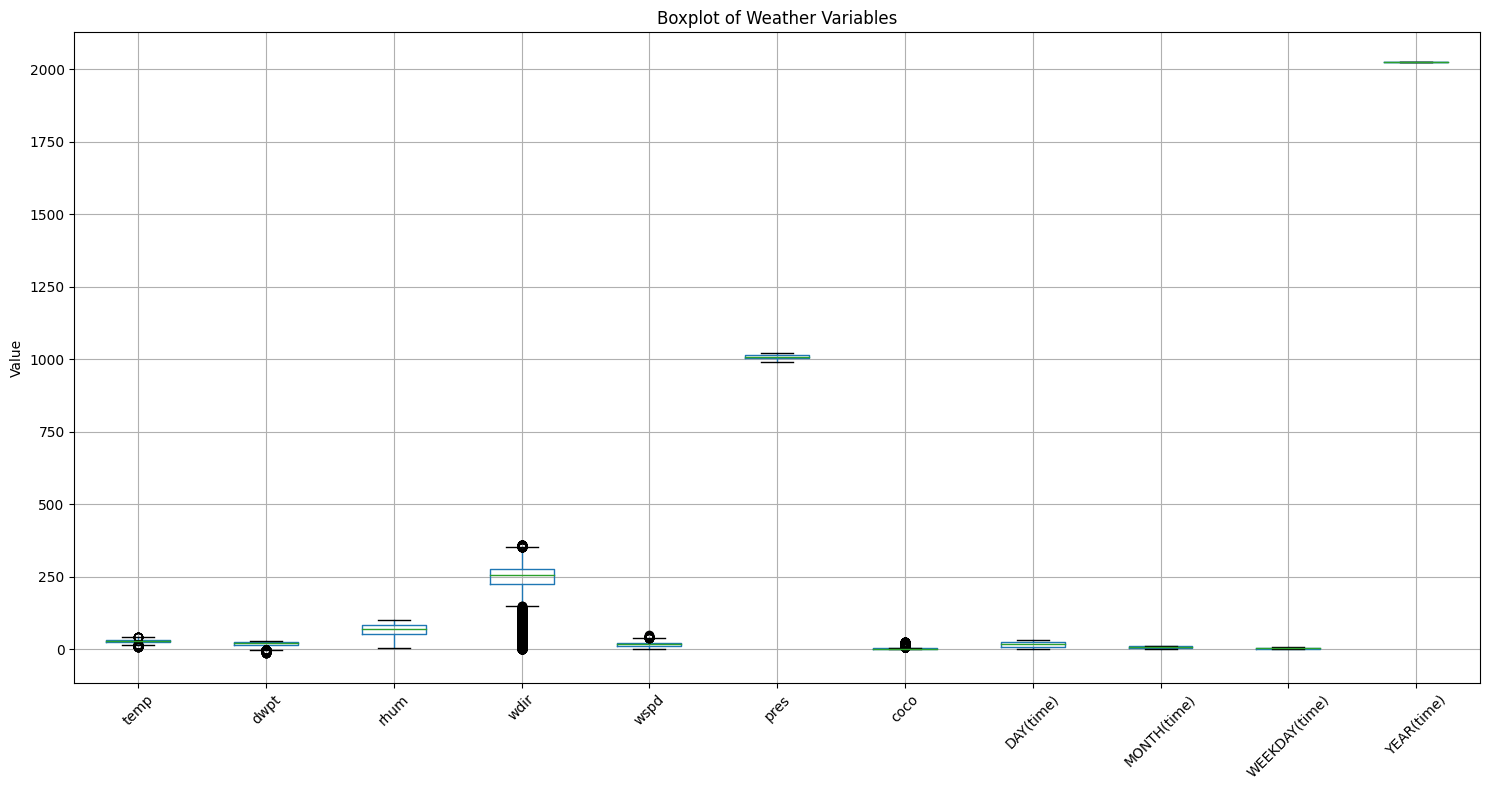

In [159]:
%matplotlib inline
import matplotlib.pyplot as plt


# List of numerical columns 
numeric_cols = ['temp','dwpt','rhum','wdir','wspd','pres','coco','DAY(time)','MONTH(time)','WEEKDAY(time)','YEAR(time)']

# Create boxplot
plt.figure(figsize=(15, 8))
data[numeric_cols].boxplot()
plt.title('Boxplot of Weather Variables')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [160]:
data.describe()

temp         dwpt         rhum         wdir         wspd  \
count  8784.000000  8784.000000  8784.000000  8784.000000  8784.000000   
mean     26.613251    18.397416    65.406535   223.473930    17.723953   
std       5.808254     8.733932    22.344286    92.050203     7.062726   
min       7.700000   -14.100000     5.000000     0.000000     0.000000   
25%      23.500000    14.000000    51.000000   224.000000    12.200000   
50%      27.800000    22.500000    70.000000   254.000000    17.300000   
75%      30.600000    24.800000    84.000000   275.000000    22.700000   
max      42.700000    28.600000   100.000000   360.000000    49.700000   

              pres         coco    DAY(time)  MONTH(time)  WEEKDAY(time)  \
count  8784.000000  8784.000000  8774.000000  8774.000000    8774.000000   
mean   1008.165107     2.000911    15.743333     6.521997       2.992934   
std       6.886456     2.094597     8.808188     3.446771       1.998904   
min     990.800000     1.000000     1.000000     1.000000       0.000000   
25%    1003.100000     1.000000     8.000000     4.000000       1.000000   
50%    1008.700000     1.000000    16.000000     7.000000       3.000000   
75%    1013.800000     3.000000    23.000000    10.000000       5.000000   
max    1022.600000    25.000000    31.000000    12.000000       6.000000   

        YEAR(time)  
count  8774.000000  
mean   2024.327103  
std       0.469182  
min    2024.000000  
25%    2024.000000  
50%    2024.000000  
75%    2025.000000  
max    2025.000000

In [161]:
# Calling AQI data
# Constants
LAT = 24.8607
LON = 67.0011
MAX_DAYS = 92
END_DATE = datetime.today()
START_DATE = END_DATE - timedelta(days=365)  # 1 year of data

all_data = []

# Break into 92-day chunks
current_start = START_DATE
while current_start < END_DATE:
    current_end = min(current_start + timedelta(days=MAX_DAYS), END_DATE)

    params = {
        "latitude": LAT,
        "longitude": LON,
        "start_date": current_start.strftime("%Y-%m-%d"),
        "end_date": current_end.strftime("%Y-%m-%d"),
        "hourly[]": ["pm10", "pm2_5"]
    }

    response = requests.get("https://air-quality-api.open-meteo.com/v1/air-quality", params=params)
    data = response.json()

    if "hourly" in data and all(k in data["hourly"] for k in ["time", "pm10", "pm2_5"]):
        df = pd.DataFrame({
            "Timestamp": data["hourly"]["time"],
            "PM10": data["hourly"]["pm10"],
            "PM2_5": data["hourly"]["pm2_5"]
        })
        all_data.append(df)
        print(f"✅ Retrieved data from {current_start.date()} to {current_end.date()}")
    else:
        print(f"❌ Failed for range {current_start.date()} to {current_end.date()}")
        print(data)

    # Move to next chunk
    current_start = current_end + timedelta(days=1)

# Combine and save
if all_data:
    full_df = pd.concat(all_data, ignore_index=True)
    full_df.to_csv("karachi_aqi_full_year.csv", index=False)
    print(f"📦 Total records: {len(full_df)}")
    print("✅ Saved full dataset to 'karachi_aqi_full_year.csv'")
else:
    print("❌ No data collected.")




✅ Retrieved data from 2024-04-30 to 2024-07-31
✅ Retrieved data from 2024-08-01 to 2024-11-01
✅ Retrieved data from 2024-11-02 to 2025-02-02
✅ Retrieved data from 2025-02-03 to 2025-04-30
📦 Total records: 8784
✅ Saved full dataset to 'karachi_aqi_full_year.csv'


In [162]:
aqi=pd.read_csv("karachi_aqi_full_year.csv")
aqi

Timestamp   PM10  PM2_5
0     2024-04-30T00:00   89.2   30.0
1     2024-04-30T01:00   89.9   29.5
2     2024-04-30T02:00   93.6   30.4
3     2024-04-30T03:00  109.4   32.7
4     2024-04-30T04:00  185.3   35.9
...                ...    ...    ...
8779  2025-04-30T19:00   23.1   16.5
8780  2025-04-30T20:00   23.0   16.2
8781  2025-04-30T21:00   22.8   15.8
8782  2025-04-30T22:00   22.8   15.4
8783  2025-04-30T23:00   22.9   15.1

[8784 rows x 3 columns]

In [163]:
aqi = aqi.drop(aqi.columns[aqi.columns.str.contains('^Unnamed')], axis=1)
aqi.head()

Timestamp   PM10  PM2_5
0  2024-04-30T00:00   89.2   30.0
1  2024-04-30T01:00   89.9   29.5
2  2024-04-30T02:00   93.6   30.4
3  2024-04-30T03:00  109.4   32.7
4  2024-04-30T04:00  185.3   35.9

In [164]:
#Merging both dataset

weather_df = pd.read_csv("Karachi_weather_data.csv")
aqi_df = pd.read_csv("karachi_aqi_full_year.csv")  


weather_df['time'] = pd.to_datetime(weather_df['time'])
aqi_df['Timestamp'] = pd.to_datetime(aqi_df['Timestamp'])

merged_df = pd.merge(weather_df,aqi_df,left_on='time',right_on='Timestamp',how='left')

merged_df = merged_df.drop('Timestamp', axis=1)

merged_df.to_csv('weather_aqi_merged.csv', index=False)
print(merged_df.head(3))

                 time  temp  dwpt  rhum   wdir  wspd    pres  coco  id  \
0 2024-04-30 00:00:00  24.4  18.3  69.0  311.0  21.6  1009.4     1   0   
1 2024-04-30 01:00:00  24.1  13.3  51.0  324.0  19.1  1010.2     1   1   
2 2024-04-30 02:00:00  25.1  13.6  49.0  328.0  19.4  1010.3     1   2   

   DAY(time)  MONTH(time)  WEEKDAY(time)  YEAR(time)  PM10  PM2_5  
0       30.0          4.0            1.0      2024.0  89.2   30.0  
1       30.0          4.0            1.0      2024.0  89.9   29.5  
2       30.0          4.0            1.0      2024.0  93.6   30.4  


In [165]:
data=pd.read_csv('weather_aqi_merged.csv')
data

time  temp  dwpt  rhum   wdir  wspd    pres  coco    id  \
0     2024-04-30 00:00:00  24.4  18.3  69.0  311.0  21.6  1009.4     1     0   
1     2024-04-30 01:00:00  24.1  13.3  51.0  324.0  19.1  1010.2     1     1   
2     2024-04-30 02:00:00  25.1  13.6  49.0  328.0  19.4  1010.3     1     2   
3     2024-04-30 03:00:00  27.9  10.1  33.0  334.0  16.2  1010.6     1     3   
4     2024-04-30 04:00:00  31.3   0.6  14.0  335.0  22.0  1010.9     1     4   
...                   ...   ...   ...   ...    ...   ...     ...   ...   ...   
8779  2025-04-30 19:00:00  27.4  23.0  77.0  261.0  20.2  1006.6     1  8779   
8780  2025-04-30 20:00:00  27.2  23.0  78.0  267.0  19.4  1006.0     1  8780   
8781  2025-04-30 21:00:00  27.1  23.1  79.0  281.0  18.0  1005.7     1  8781   
8782  2025-04-30 22:00:00  27.1  23.1  79.0  273.0  18.0  1005.1     1  8782   
8783  2025-04-30 23:00:00  26.8  23.3  81.0  270.0  15.5  1005.1     1  8783   

      DAY(time)  MONTH(time)  WEEKDAY(time)  YEAR(time)   PM10  PM2_5  
0          30.0          4.0            1.0      2024.0   89.2   30.0  
1          30.0          4.0            1.0      2024.0   89.9   29.5  
2          30.0          4.0            1.0      2024.0   93.6   30.4  
3          30.0          4.0            1.0      2024.0  109.4   32.7  
4          30.0          4.0            1.0      2024.0  185.3   35.9  
...         ...          ...            ...         ...    ...    ...  
8779        NaN          NaN            NaN         NaN   23.1   16.5  
8780        NaN          NaN            NaN         NaN   23.0   16.2  
8781        NaN          NaN            NaN         NaN   22.8   15.8  
8782        NaN          NaN            NaN         NaN   22.8   15.4  
8783        NaN          NaN            NaN         NaN   22.9   15.1  

[8784 rows x 15 columns]

In [166]:
c_data=data.drop('id',axis=1,inplace=True)

In [167]:
data= data.drop(data.columns[data.columns.str.contains('^Unnamed')], axis=1)
data.head()

time  temp  dwpt  rhum   wdir  wspd    pres  coco  \
0  2024-04-30 00:00:00  24.4  18.3  69.0  311.0  21.6  1009.4     1   
1  2024-04-30 01:00:00  24.1  13.3  51.0  324.0  19.1  1010.2     1   
2  2024-04-30 02:00:00  25.1  13.6  49.0  328.0  19.4  1010.3     1   
3  2024-04-30 03:00:00  27.9  10.1  33.0  334.0  16.2  1010.6     1   
4  2024-04-30 04:00:00  31.3   0.6  14.0  335.0  22.0  1010.9     1   

   DAY(time)  MONTH(time)  WEEKDAY(time)  YEAR(time)   PM10  PM2_5  
0       30.0          4.0            1.0      2024.0   89.2   30.0  
1       30.0          4.0            1.0      2024.0   89.9   29.5  
2       30.0          4.0            1.0      2024.0   93.6   30.4  
3       30.0          4.0            1.0      2024.0  109.4   32.7  
4       30.0          4.0            1.0      2024.0  185.3   35.9

In [168]:
# Checking and Removing the Outliers

# list of features
weather_features = ['temp', 'dwpt', 'rhum','wdir', 'wspd', 'pres','coco', 'PM10', 'PM2_5','DAY(time)','MONTH(time)','WEEKDAY(time)','YEAR(time)','PM10','PM2_5'] 

# Making a copy
cleaned_data = data.copy()

# Creating a mask to keep original data
mask = np.ones(len(cleaned_data), dtype=bool)

for feature in weather_features:
    Q1 = cleaned_data[feature].quantile(0.25)
    Q3 = cleaned_data[feature].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    feature_mask = (cleaned_data[feature] >= lower_bound) & (cleaned_data[feature] <= upper_bound)
    
    # Combining masks to keep only rows that are NOT outliers
    mask = mask & feature_mask

# Apply mask once at the end
cleaned_data = cleaned_data[mask]

# Final date check
print("Last date after cleaning:", cleaned_data['time'].max())


Last date after cleaning: 2025-04-30 13:00:00


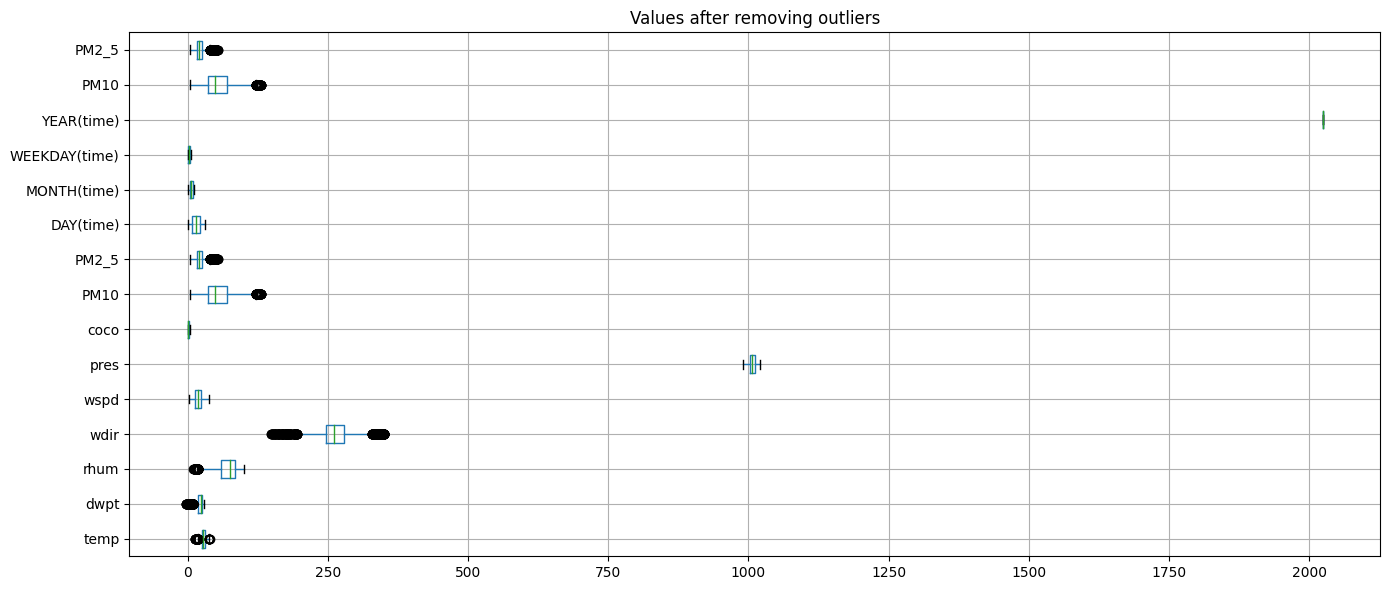

In [169]:
plt.figure(figsize=(14, 6))
cleaned_data.boxplot(column=weather_features, vert=False)
plt.title('Values after removing outliers')
plt.grid(True)
plt.tight_layout()
plt.show()


In [170]:
cleaned_data.tail()

time  temp  dwpt  rhum   wdir  wspd    pres  coco  \
8769  2025-04-30 09:00:00  35.0  20.6  43.0  257.0  25.9  1005.4     3   
8770  2025-04-30 10:00:00  34.3  21.0  46.0  252.0  25.6  1004.7     3   
8771  2025-04-30 11:00:00  33.5  21.0  48.0  249.0  28.1  1004.2     3   
8772  2025-04-30 12:00:00  32.4  21.0  51.0  249.0  28.4  1004.1     3   
8773  2025-04-30 13:00:00  31.2  21.4  56.0  252.0  26.6  1004.2     2   

      DAY(time)  MONTH(time)  WEEKDAY(time)  YEAR(time)  PM10  PM2_5  
8769       30.0          4.0            2.0      2025.0  23.0   13.5  
8770       30.0          4.0            2.0      2025.0  22.4   13.4  
8771       30.0          4.0            2.0      2025.0  21.7   13.3  
8772       30.0          4.0            2.0      2025.0  21.1   13.8  
8773       30.0          4.0            2.0      2025.0  21.2   14.8

In [171]:
cleaned_data.count()

time             6070
temp             6070
dwpt             6070
rhum             6070
wdir             6070
wspd             6070
pres             6070
coco             6070
DAY(time)        6070
MONTH(time)      6070
WEEKDAY(time)    6070
YEAR(time)       6070
PM10             6070
PM2_5            6070
dtype: int64

In [172]:
cleaned_data.to_csv('Karachi_Weather_aqi_Dataset.csv',index=False)
data=pd.read_csv('Karachi_Weather_aqi_Dataset.csv')
data

time  temp  dwpt  rhum   wdir  wspd    pres  coco  \
0     2024-04-30 00:00:00  24.4  18.3  69.0  311.0  21.6  1009.4     1   
1     2024-04-30 01:00:00  24.1  13.3  51.0  324.0  19.1  1010.2     1   
2     2024-04-30 02:00:00  25.1  13.6  49.0  328.0  19.4  1010.3     1   
3     2024-04-30 03:00:00  27.9  10.1  33.0  334.0  16.2  1010.6     1   
4     2024-04-30 12:00:00  34.2   6.5  18.0  248.0  26.3  1005.7     1   
...                   ...   ...   ...   ...    ...   ...     ...   ...   
6065  2025-04-30 09:00:00  35.0  20.6  43.0  257.0  25.9  1005.4     3   
6066  2025-04-30 10:00:00  34.3  21.0  46.0  252.0  25.6  1004.7     3   
6067  2025-04-30 11:00:00  33.5  21.0  48.0  249.0  28.1  1004.2     3   
6068  2025-04-30 12:00:00  32.4  21.0  51.0  249.0  28.4  1004.1     3   
6069  2025-04-30 13:00:00  31.2  21.4  56.0  252.0  26.6  1004.2     2   

      DAY(time)  MONTH(time)  WEEKDAY(time)  YEAR(time)   PM10  PM2_5  
0          30.0          4.0            1.0      2024.0   89.2   30.0  
1          30.0          4.0            1.0      2024.0   89.9   29.5  
2          30.0          4.0            1.0      2024.0   93.6   30.4  
3          30.0          4.0            1.0      2024.0  109.4   32.7  
4          30.0          4.0            1.0      2024.0  121.5   23.2  
...         ...          ...            ...         ...    ...    ...  
6065       30.0          4.0            2.0      2025.0   23.0   13.5  
6066       30.0          4.0            2.0      2025.0   22.4   13.4  
6067       30.0          4.0            2.0      2025.0   21.7   13.3  
6068       30.0          4.0            2.0      2025.0   21.1   13.8  
6069       30.0          4.0            2.0      2025.0   21.2   14.8  

[6070 rows x 14 columns]

In [173]:
# Rename date columns
data = data.rename(columns={
    'DAY(time)': 'Day',
    'MONTH(time)': 'Month',
    'WEEKDAY(time)': 'Weekday',
    'YEAR(time)': 'Year'
})

data = data.drop(columns=[col for col in ['Unnamed: 0'] if col in data.columns])


In [174]:
data['time'] = pd.to_datetime(data['time'])

In [175]:
data.dtypes

time       datetime64[ns]
temp              float64
dwpt              float64
rhum              float64
wdir              float64
wspd              float64
pres              float64
coco                int64
Day               float64
Month             float64
Weekday           float64
Year              float64
PM10              float64
PM2_5             float64
dtype: object

In [176]:
data.head()

time  temp  dwpt  rhum   wdir  wspd    pres  coco   Day  \
0 2024-04-30 00:00:00  24.4  18.3  69.0  311.0  21.6  1009.4     1  30.0   
1 2024-04-30 01:00:00  24.1  13.3  51.0  324.0  19.1  1010.2     1  30.0   
2 2024-04-30 02:00:00  25.1  13.6  49.0  328.0  19.4  1010.3     1  30.0   
3 2024-04-30 03:00:00  27.9  10.1  33.0  334.0  16.2  1010.6     1  30.0   
4 2024-04-30 12:00:00  34.2   6.5  18.0  248.0  26.3  1005.7     1  30.0   

   Month  Weekday    Year   PM10  PM2_5  
0    4.0      1.0  2024.0   89.2   30.0  
1    4.0      1.0  2024.0   89.9   29.5  
2    4.0      1.0  2024.0   93.6   30.4  
3    4.0      1.0  2024.0  109.4   32.7  
4    4.0      1.0  2024.0  121.5   23.2

In [177]:
data.tail()

time  temp  dwpt  rhum   wdir  wspd    pres  coco   Day  \
6065 2025-04-30 09:00:00  35.0  20.6  43.0  257.0  25.9  1005.4     3  30.0   
6066 2025-04-30 10:00:00  34.3  21.0  46.0  252.0  25.6  1004.7     3  30.0   
6067 2025-04-30 11:00:00  33.5  21.0  48.0  249.0  28.1  1004.2     3  30.0   
6068 2025-04-30 12:00:00  32.4  21.0  51.0  249.0  28.4  1004.1     3  30.0   
6069 2025-04-30 13:00:00  31.2  21.4  56.0  252.0  26.6  1004.2     2  30.0   

      Month  Weekday    Year  PM10  PM2_5  
6065    4.0      2.0  2025.0  23.0   13.5  
6066    4.0      2.0  2025.0  22.4   13.4  
6067    4.0      2.0  2025.0  21.7   13.3  
6068    4.0      2.0  2025.0  21.1   13.8  
6069    4.0      2.0  2025.0  21.2   14.8

In [178]:
import os

# Skip this part during CI/CD pipeline
if os.environ.get("CI") != "true":
    from google.oauth2 import service_account
    from google.cloud import bigquery
    from pandas_gbq import to_gbq

    credentials = service_account.Credentials.from_service_account_file(
        r"C:\Users\Arbaz Aslam\arbaz-aslam-aqi-prediction-b20d9ef70aaf.json"
    )

    project_id = "arbaz-aslam-aqi-prediction"
    dataset_id = "aqi_feature_store"
    table_id = "weather_aqi_features"

    client = bigquery.Client(credentials=credentials, project=project_id)

    data['time'] = pd.to_datetime(data['time'])
    data = data.sort_values('time')

    to_gbq(
        data,
        destination_table=f"{dataset_id}.{table_id}",
        project_id=project_id,
        if_exists='replace',
        credentials=credentials
    )


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [179]:
import os
import pandas as pd

if os.getenv("CI"):
    # Running in GitHub Actions, use dummy data
    df_features = pd.DataFrame({
        'temperature': [25, 26, 24],
        'humidity': [60, 65, 55],
        'PM10': [80, 85, 90]
    })
    print("Using dummy DataFrame in CI environment")
else:
    # Local run: fetch real data from BigQuery
    from google.oauth2 import service_account
    from pandas_gbq import read_gbq

    credentials = service_account.Credentials.from_service_account_file(r"C:\Users\Arbaz Aslam\arbaz-aslam-aqi-prediction-b20d9ef70aaf.json")

    query = """
    SELECT *
    FROM `arbaz-aslam-aqi-prediction.aqi_feature_store.weather_aqi_features`
    ORDER BY time
    """
    df_features = pd.read_gbq(query, project_id="arbaz-aslam-aqi-prediction", credentials=credentials)


df_features.describe()


time         temp         dwpt         rhum  \
count                        6070  6070.000000  6070.000000  6070.000000   
mean   2024-10-21 03:07:03.459637    28.127677    21.305354    70.041351   
min           2024-04-30 00:00:00    13.800000    -2.200000    10.000000   
25%           2024-07-14 23:15:00    25.900000    18.900000    59.000000   
50%           2024-10-05 04:30:00    28.400000    23.500000    75.000000   
75%           2025-02-15 00:45:00    30.800000    25.000000    85.000000   
max           2025-04-30 13:00:00    40.400000    28.600000   100.000000   
std                           NaN     4.094467     5.638157    19.714149   

              wdir         wspd         pres      coco          Day  \
count  6070.000000  6070.000000  6070.000000    6070.0  6070.000000   
mean    264.414003    19.013641  1006.896524  1.783361    15.499176   
min     148.000000     1.800000   990.800000       1.0     1.000000   
25%     246.000000    13.700000  1003.000000       1.0     8.000000   
50%     262.000000    18.700000  1007.100000       1.0    15.000000   
75%     279.000000    24.100000  1011.800000       3.0    23.000000   
max     351.000000    37.800000  1021.100000       5.0    31.000000   
std      30.834878     6.732069     5.852525  0.927076     8.596227   

             Month      Weekday         Year         PM10        PM2_5  
count  6070.000000  6070.000000  6070.000000  6070.000000  6070.000000  
mean      6.437232     2.975288  2024.311367    55.762932    22.101203  
min       1.000000     0.000000  2024.000000     3.900000     3.800000  
25%       4.000000     1.000000  2024.000000    36.725000    16.600000  
50%       6.000000     3.000000  2024.000000    49.700000    20.500000  
75%       9.000000     5.000000  2025.000000    70.800000    26.200000  
max      12.000000     6.000000  2025.000000   130.400000    53.700000  
std       3.003474     1.984961     0.463091    26.280301     7.989679

In [180]:
df_features.head()

time  temp  dwpt  rhum   wdir  wspd    pres  coco   Day  \
0 2024-04-30 00:00:00  24.4  18.3  69.0  311.0  21.6  1009.4     1  30.0   
1 2024-04-30 01:00:00  24.1  13.3  51.0  324.0  19.1  1010.2     1  30.0   
2 2024-04-30 02:00:00  25.1  13.6  49.0  328.0  19.4  1010.3     1  30.0   
3 2024-04-30 03:00:00  27.9  10.1  33.0  334.0  16.2  1010.6     1  30.0   
4 2024-04-30 12:00:00  34.2   6.5  18.0  248.0  26.3  1005.7     1  30.0   

   Month  Weekday    Year   PM10  PM2_5  
0    4.0      1.0  2024.0   89.2   30.0  
1    4.0      1.0  2024.0   89.9   29.5  
2    4.0      1.0  2024.0   93.6   30.4  
3    4.0      1.0  2024.0  109.4   32.7  
4    4.0      1.0  2024.0  121.5   23.2

In [181]:
df_features.tail()

time  temp  dwpt  rhum   wdir  wspd    pres  coco   Day  \
6065 2025-04-30 09:00:00  35.0  20.6  43.0  257.0  25.9  1005.4     3  30.0   
6066 2025-04-30 10:00:00  34.3  21.0  46.0  252.0  25.6  1004.7     3  30.0   
6067 2025-04-30 11:00:00  33.5  21.0  48.0  249.0  28.1  1004.2     3  30.0   
6068 2025-04-30 12:00:00  32.4  21.0  51.0  249.0  28.4  1004.1     3  30.0   
6069 2025-04-30 13:00:00  31.2  21.4  56.0  252.0  26.6  1004.2     2  30.0   

      Month  Weekday    Year  PM10  PM2_5  
6065    4.0      2.0  2025.0  23.0   13.5  
6066    4.0      2.0  2025.0  22.4   13.4  
6067    4.0      2.0  2025.0  21.7   13.3  
6068    4.0      2.0  2025.0  21.1   13.8  
6069    4.0      2.0  2025.0  21.2   14.8

In [ ]:
# Checking if 'PM2_5' column exists
if 'PM2_5' in df_features.columns:
    # Creating target columns for PM10 and PM2.5 for the next 3 days
    for i in range(1, 4):
        df_features[f'PM10_day{i}'] = df_features['PM10'].shift(-i)
        df_features[f'PM2_5_day{i}'] = df_features['PM2_5'].shift(-i)  # Ensure 'PM2_5' column exists

    # Dropping rows with NaN values
    df_model = df_features.dropna().reset_index(drop=True)

    # Defining feature and target columns
    feature_cols = ['temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres', 'coco', 'Day', 'Month', 'Weekday', 'Year']
    target_cols = [f'PM10_day{i}' for i in range(1, 4)] + [f'PM2_5_day{i}' for i in range(1, 4)]

    X_raw = df_model[feature_cols]
    y_raw = df_model[target_cols]

    # Splitting into training and testing sets
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

    # Scaling features and targets
    X_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    X_train = X_scaler.fit_transform(X_train_raw)
    X_test = X_scaler.transform(X_test_raw)

    y_train = y_scaler.fit_transform(y_train_raw)
    y_test = y_scaler.transform(y_test_raw)

    # Saving the scalers
    joblib.dump(X_scaler, "x_scaler.pkl")
    joblib.dump(y_scaler, "y_scaler.pkl")

    # Defining models
    models = {
        'RandomForest': RandomForestRegressor(random_state=42),
        'AdaBoost': AdaBoostRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42, verbosity=0),
        'LightGBM': LGBMRegressor(random_state=42, verbose=-1),
        'CatBoost': CatBoostRegressor(verbose=0, random_state=42)
    }

    # Hyperparameter grids
    param_grids = {
        'RandomForest': {
            'estimator__n_estimators': [100, 200],
            'estimator__max_depth': [5, 10, 15],
            'estimator__min_samples_split': [2, 5]
        },
        'AdaBoost': {
            'estimator__n_estimators': [50, 100],
            'estimator__learning_rate': [0.01, 0.1, 1]
        },
        'XGBoost': {
            'estimator__n_estimators': [100, 200],
            'estimator__learning_rate': [0.01, 0.1, 0.2],
            'estimator__max_depth': [3, 5, 7]
        },
        'LightGBM': {
            'estimator__n_estimators': [100, 200],
            'estimator__learning_rate': [0.01, 0.1],
            'estimator__max_depth': [5, 10],
            'estimator__num_leaves': [31, 50]
        },
        'CatBoost': {
            'estimator__iterations': [100, 200],
            'estimator__learning_rate': [0.01, 0.1],
            'estimator__depth': [5, 10]
        }
    }

    # Wrapping models with MultiOutputRegressor
    wrapped_models = {name: MultiOutputRegressor(model) for name, model in models.items()}

    # Store results
    results = []
    best_estimators = {}

    # Training and tuning
    for name, model in wrapped_models.items():
        print(f"🔍 Tuning {name}...")

        grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        best_estimators[name] = best_model

        preds_scaled = best_model.predict(X_test)
        preds = y_scaler.inverse_transform(preds_scaled)
        y_test_unscaled = y_scaler.inverse_transform(y_test)

        rmse = np.sqrt(mean_squared_error(y_test_unscaled, preds))
        mae = mean_absolute_error(y_test_unscaled, preds)
        r2 = r2_score(y_test_unscaled, preds)

        results.append((name, grid_search.best_params_, rmse, mae, r2))

    # Define top_3 if results are available
    if results:
        results.sort(key=lambda x: x[2])  # Sort by RMSE
        top_3 = results[:3]
    else:
        top_3 = []

    # Display top 3 models
    if top_3:
        print("\n🏆 Top 3 Models (Lowest RMSE):")
        for i, (name, best_params, rmse, mae, r2) in enumerate(top_3, 1):
            print(f"{i}. {name}: RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.2f}, Best Params={best_params}")
    else:
        print("No valid models found or no results available for logging.")
else:
    print("PM2_5 column is missing from the DataFrame")


🔍 Tuning RandomForest...
🔍 Tuning AdaBoost...
🔍 Tuning XGBoost...
🔍 Tuning LightGBM...
🔍 Tuning CatBoost...


In [ ]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# Ensure top_3 is defined
if 'top_3' in locals() and top_3:
    mlflow.set_experiment("AQI_Prediction_Experiment")

    with mlflow.start_run(run_name=f"{top_3[0][0]}_Best_Model_Run"):
        # Log hyperparameters
        mlflow.log_params(top_3[0][1])

        # Log evaluation metrics
        mlflow.log_metric("rmse", top_3[0][2])
        mlflow.log_metric("mae", top_3[0][3])
        mlflow.log_metric("r2", top_3[0][4])

        # Create model signature
        signature = infer_signature(X_train_raw, y_scaler.inverse_transform(best_estimators[top_3[0][0]].predict(X_train_raw)))

        # Log and register model
        mlflow.sklearn.log_model(
            sk_model=best_estimators[top_3[0][0]],
            artifact_path="best_model",
            signature=signature,
            registered_model_name="AQI_Best_Model"
        )
else:
    print("No top model available for logging.")


In [ ]:
#line to loggedin in mlflow ui: 
#mlflow ui --backend-store-uri file:///C:/Users/Arbaz%20Aslam/Python%20work/Arbaz_Aslam_AQI_Project/mlruns